# Multi Layer Perceptron

パーセプトロンを複数レイヤーつなげて、学習させてみる。活性化関数としては、reluを使い、最後の評価は`L.Classifier`のデフォルトで使うことにする。最適化アルゴリズムはAdamを使う。

In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

In [2]:
import pickle, gzip
f = gzip.open('../data/mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
print(len(train_set[0]), len(valid_set[0]), len(test_set[0]))
train_set_x, train_set_y  = train_set
test_set_x, test_set_y = test_set
print(len(train_set_x[0]))
print(train_set_x)
print("28x28の画像のモノクロ(白0→黒1)が１次元配列で入っている",train_set_x[:5])
print("最初のラベルは",train_set_y[0])

# あとで、softmax_cross_entropyを使うときに型の判定があり、np.int32じゃないといけない
train_set_y = train_set_y.astype(np.int32)
test_set_y = test_set_y.astype(np.int32)
print(train_set_y )
f.close()

50000 10000 10000
784
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
28x28の画像のモノクロ(白0→黒1)が１次元配列で入っている [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
最初のラベルは 5
[5 0 4 ..., 8 4 8]


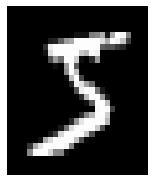

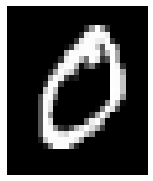

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
def draw_digit(data, size=28):
    plt.figure(figsize=(2.5, 3))

    X, Y = np.meshgrid(range(size),range(size))
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,size-1)
    plt.ylim(0,size-1)
    plt.pcolor(X, Y, Z)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

    plt.show()

draw_digit(train_set_x[0])
draw_digit(train_set_x[1])

In [4]:
class MNISTMLPerceptron(Chain):
    def __init__(self, hidden_num=1024, input_num = 784, output_num = 10):
        super(MNISTMLPerceptron, self).__init__(
            l1 = L.Linear(input_num, hidden_num),
            l2 = L.Linear(hidden_num, hidden_num),
            l3 = L.Linear(hidden_num, output_num)
        )
        self.input_num = input_num
        self.hidden_num = hidden_num
        self.output_num = output_num
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)
    
model = L.Classifier(MNISTMLPerceptron())

In [5]:
optimizer = optimizers.Adam()
optimizer.setup(model)

batch_size = 100
for step in range(1001):
    batch_index = np.random.randint(len(train_set[0])-batch_size)
    batch_x = Variable(train_set_x[batch_index:batch_index+batch_size])
    batch_y = Variable(train_set_y[batch_index:batch_index+batch_size])
    optimizer.update(model, batch_x, batch_y)
    if step % 100 == 0:
        print(step, model.accuracy.data)
    

0 0.10999999940395355
100 0.949999988079071
200 0.9800000190734863
300 0.9100000262260437
400 0.9800000190734863
500 0.9900000095367432
600 0.9800000190734863
700 0.9800000190734863
800 0.9900000095367432
900 0.949999988079071
1000 0.9800000190734863


In [6]:
model(Variable(test_set_x),Variable(test_set_y))
print("精度 →",model.accuracy.data)

精度 → 0.972599983215332


97%ぐらいの制度が出る

次は、各層にdropoutを入れてみる。これは一般的には過学習を防ぐためと言われている。

In [7]:
class MNISTMLPerceptronDropout(MNISTMLPerceptron):
    def __call__(self, x):
        h1 = F.dropout(F.relu(self.l1(x)))
        h2 = F.dropout(F.relu(self.l2(h1)))
        return self.l3(h2)

In [8]:
model = L.Classifier(MNISTMLPerceptronDropout())
optimizer.setup(model)
batch_size = 100
for step in range(1001):
    batch_index = np.random.randint(len(train_set[0])-batch_size)
    batch_x = Variable(train_set_x[batch_index:batch_index+batch_size])
    batch_y = Variable(train_set_y[batch_index:batch_index+batch_size])
    optimizer.update(model, batch_x, batch_y)
    if step % 100 == 0:
        print(step, model.accuracy.data)

0 0.07999999821186066
100 0.8799999952316284
200 0.9700000286102295
300 0.949999988079071
400 0.9599999785423279
500 0.9399999976158142
600 0.9399999976158142
700 0.9800000190734863
800 0.9599999785423279
900 0.9800000190734863
1000 0.9700000286102295


In [9]:
model(Variable(test_set_x),Variable(test_set_y))
print("精度 →",model.accuracy.data)

精度 → 0.9581000208854675


ドロップアウトしたほうが、精度が低くなった。。。あれ？

# Autoencoderのファインチューニング

ニューラルネットワークの階層が深くなっていくと、学習の速度が遅くなっていくことが知られている。それはパメーターの更新時が、深い階層で消失してしまうためであろうと考えられている。

そのための対策法として、プレ学習というものが使われることがあり、その手法としてAutoencoderという教師なし学習が使われることがある。

Autoencoderは入力層をそっくりそのまま出力層で再現するニューラルネットワークで、その学習したパラメーターを初期値として、クラス分類のニューラルネットワークを作ろうとする。

そうすることにより、よりよい学習が行われる。

まずはAutoencorderを作ってみる

In [10]:
class Autoencoder(Chain):
    def __init__(self, input_layer_num = 784, hidden_layer_num=1024):
        super(Autoencoder, self).__init__(
            l1 = L.Linear(input_layer_num, hidden_layer_num),
            l2 = L.Linear(hidden_layer_num, input_layer_num)
        )
        
    def __call__(self, x):
        h2 = self.predict(x)
        self.accuracy = F.mean_squared_error(h2, x)
        return self.accuracy
    
    def predict(self, x):
        h1 = F.relu(self.l1(x))
        h2 = self.l2(h1)
        return h2

In [11]:
a1 = Autoencoder()
optimizer = optimizers.Adam()
optimizer.setup(a1)

batch_size = 100
for step in range(1001):
    batch_index = np.random.randint(len(train_set[0])-batch_size)
    batch_x = Variable(train_set_x[batch_index:batch_index+batch_size])
    optimizer.update(a1, batch_x)
    if step % 100 == 0:
        print(step, a1.accuracy.data)

0 0.15395627915859222
100 0.012477193027734756
200 0.006809466518461704
300 0.005883700214326382
400 0.003752612741664052
500 0.002853567246347666
600 0.0028303395956754684
700 0.002062590792775154
800 0.0022276584059000015
900 0.0028191173914819956
1000 0.0019323721062391996


In [12]:
predict1 = a1.predict(Variable(test_set_x))

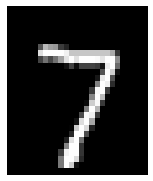

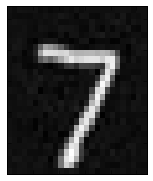

In [13]:
draw_digit(test_set_x[0])
draw_digit(predict1.data[0])

In [14]:
modelFromAE = L.Classifier(MNISTMLPerceptronDropout())
modelFromAE.predictor.l1 = a1.l1.copy()

In [15]:
optimizer = optimizers.Adam()
optimizer.setup(modelFromAE)

batch_size = 100
for step in range(1001):
    batch_index = np.random.randint(len(train_set[0])-batch_size)
    batch_x = Variable(train_set_x[batch_index:batch_index+batch_size])
    batch_y = Variable(train_set_y[batch_index:batch_index+batch_size])
    optimizer.update(modelFromAE, batch_x, batch_y)
    if step % 100 == 0:
        print(step, modelFromAE.accuracy.data)

0 0.09000000357627869
100 0.8100000023841858
200 0.9100000262260437
300 0.800000011920929
400 0.9599999785423279
500 0.949999988079071
600 0.9100000262260437
700 0.9200000166893005
800 0.9599999785423279
900 0.9700000286102295
1000 0.9900000095367432


In [16]:
modelFromAE(Variable(test_set_x),Variable(test_set_y))
print("精度 →",modelFromAE.accuracy.data)

精度 → 0.9546999931335449


階層がそれほど深くないからか、あまり意味がなかった？


In [17]:
modelFromAE = L.Classifier(MNISTMLPerceptron())
modelFromAE.predictor.l1 = a1.l1.copy()
optimizer = optimizers.Adam()
optimizer.setup(modelFromAE)

batch_size = 100
for step in range(1001):
    batch_index = np.random.randint(len(train_set[0])-batch_size)
    batch_x = Variable(train_set_x[batch_index:batch_index+batch_size])
    batch_y = Variable(train_set_y[batch_index:batch_index+batch_size])
    optimizer.update(modelFromAE, batch_x, batch_y)
    if step % 100 == 0:
        print(step, modelFromAE.accuracy.data)
modelFromAE(Variable(test_set_x),Variable(test_set_y))
print("精度 →",modelFromAE.accuracy.data)

0 0.07999999821186066
100 0.9800000190734863
200 0.9900000095367432
300 0.9700000286102295
400 0.9599999785423279
500 0.9800000190734863
600 1.0
700 0.9800000190734863
800 0.9800000190734863
900 0.9800000190734863
1000 1.0
精度 → 0.9765999913215637


悩ましい。。。何もやらないほうが制度が高い。。。